<a href="https://colab.research.google.com/github/jdlozanom/deep-learning-experiments/blob/master/Voice_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Updated notebook at repository: https://github.com/jdlozanom/deep-learning-experiments/blob/master/Voice_recognition.ipynb

# Init
Install dependencies and initialize imports

In [0]:
!pip install pytube3
!pip install -U librosa

from pytube import YouTube
import os
import matplotlib.pyplot as plt
import librosa
import numpy as np
import librosa.display
import pandas as pd

import IPython
from IPython.display import Audio

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from IPython.display import clear_output

clear_output()

# Video download

In [0]:
# Dictionary with youtube ids from source videos
videos_dict = {
    "errejon" : ['AjiHJNRz7BQ', 'yQzapET06cA', 'mt1YrvamC9c','Zx6fZ7XwnIg','_-oQ85JmzAI'],
    "casado" : ['eMJvJZo8t0U','hn5RYH94O74', 'HJZJIEJBwHU', 'yfqQ2YSculg','FbqXVMabwx8'],
    "sanchez" : ['r8Jk70Mo_10','TdUuzUR_mBM', '1t53omZSGwY','54jcoRjqJnw','CG7fHbhiY6w'],
    "arrimadas" : ['eK13K9wpSmw','hLCQvH5iiA8','9k3S1P6yU_k','bleasmBwPmk','lv-XwbaDHDE'],
    "abascal" : ['M5jkThdskT4','8Kufi9BxLI4','NgdEwEf9Imk','WTYHTHFCvL0','6IIj8IbeFuA'],
    "iglesias" : ['HBbCQnDwNBc','Dp-1lAoMd5I','_hFm83S1RaE','QcIt1F8oUS4','KJ19erX1L_4']
}

num_videos = sum([len(v) for v in videos_dict.values()])

In [15]:
VIDEOS_PATH = '.'
VIDEOS_EXTENSION = '.mp4' 
AUDIO_EXT = 'wav'

# Video download function using pytube
def dowload_video(video_list):
  for video_name in video_list:
    video = YouTube('https://www.youtube.com/watch?v={}'.format(video_name))
    video.streams.filter(type = "audio", file_extension = "mp4").all()[0].download(filename=video_name)


# Download process
for key in list(videos_dict.keys()):
  dowload_video(videos_dict[key])

# Check
assert len([f for f in os.listdir(VIDEOS_PATH) if f.endswith(VIDEOS_EXTENSION)]) == num_videos
clear_output()
print('Videos downloaded')

Videos downloaded


In [16]:
# Convert videos to wav
EXTRACT_VIDEO_COMMAND = ('ffmpeg -i "{from_video_path}" '
                         '-f {audio_ext} -ab 32k -ac 1 -ss 6 '
                         '-vn "{to_audio_path}"')

files = os.listdir(VIDEOS_PATH)
for f in files:
    if not f.endswith(VIDEOS_EXTENSION):
        continue

    audio_file_name = '{}.{}'.format(f[:-len(VIDEOS_EXTENSION)], AUDIO_EXT)
    command = EXTRACT_VIDEO_COMMAND.format(
        from_video_path=f, audio_ext=AUDIO_EXT, to_audio_path=audio_file_name,
    )
    os.system(command)

assert len([f for f in os.listdir(VIDEOS_PATH) if f.endswith(AUDIO_EXT)]) == sum([len(v) for v in videos_dict.values()])
os.system('rm *mp4')
clear_output()
print('Audio created')

Audio created


# Data Exploration

In [0]:
y, sr = librosa.load('TdUuzUR_mBM.wav')
S = librosa.feature.melspectrogram(y=y, sr=sr)

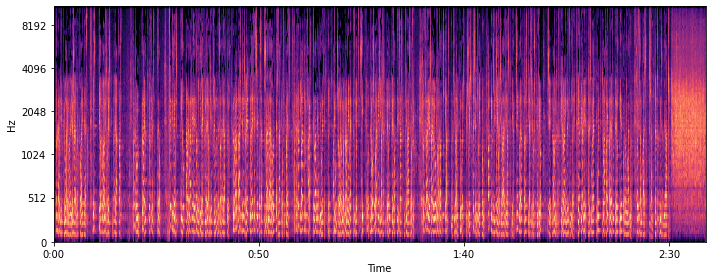

In [0]:
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                       y_axis='mel', sr=sr)

plt.tight_layout()
plt.show()

In [0]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128)
mfccsscaled = np.mean(mfccs.T,axis=1)

df = pd.DataFrame(mfccs[:,0:128])
df = pd.DataFrame(mfccs)
df

NameError: ignored

In [0]:
#df_out = df.loc[:,df.iloc[0] != -480.182159]
df_out = df.loc[:,df.iloc[0] > mfccs.min()*3/5]

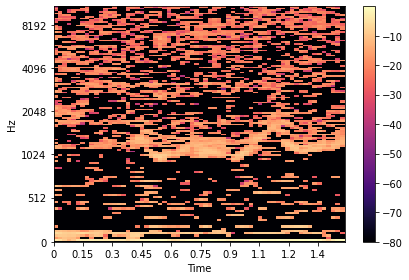

In [0]:
#librosa.display.specshow(df_out.values[:,0:128], x_axis='time')
S_dB = librosa.power_to_db(df_out.values[:,:64], ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                       y_axis='mel', sr=sr)

plt.colorbar()
plt.tight_layout()
plt.show()

In [0]:
audio = librosa.feature.inverse.mfcc_to_audio(df_out.values[:,0:64])
librosa.output.write_wav('new.wav', audio, sr=21500)
IPython.display.display(Audio('new.wav'))

/usr/local/lib/python3.6/dist-packages/librosa/output.py:198: DeprecationWarning: librosa.output.write_wav
	Deprecated as of librosa version 0.7.0.
	It will be removed in librosa version 0.8.
  def write_wav(path, y, sr, norm=False):


# Data prep


In [17]:
# Output arrays X, y and source for store original audio ids
X = []
y = []
source = []

for person_id, person in enumerate(list(videos_dict.keys())):
  for audio_id in videos_dict[person]:
    print(person_id, person, audio_id)
    audio_ts, sr = librosa.load(f'{audio_id}.wav')
    mfccs = librosa.feature.mfcc(y=audio_ts, sr=sr, n_mfcc=128)
    df = pd.DataFrame(mfccs)
    df_out = df.loc[:,df.iloc[0] > mfccs.min()*3/5]

    audio_len = mfccs.shape[1]
    for i in range(0, audio_len - (audio_len // 5), 64):
      X.append(mfccs[:,i:i+64].ravel())
      y.append(person_id)
      source.append(audio_id)

0 errejon AjiHJNRz7BQ
0 errejon yQzapET06cA
0 errejon mt1YrvamC9c
0 errejon Zx6fZ7XwnIg
0 errejon _-oQ85JmzAI
1 casado eMJvJZo8t0U
1 casado hn5RYH94O74
1 casado HJZJIEJBwHU
1 casado yfqQ2YSculg
1 casado FbqXVMabwx8
2 sanchez r8Jk70Mo_10
2 sanchez TdUuzUR_mBM
2 sanchez 1t53omZSGwY
2 sanchez 54jcoRjqJnw
2 sanchez CG7fHbhiY6w
3 arrimadas eK13K9wpSmw
3 arrimadas hLCQvH5iiA8
3 arrimadas 9k3S1P6yU_k
3 arrimadas bleasmBwPmk
3 arrimadas lv-XwbaDHDE
4 abascal M5jkThdskT4
4 abascal 8Kufi9BxLI4
4 abascal NgdEwEf9Imk
4 abascal WTYHTHFCvL0
4 abascal 6IIj8IbeFuA
5 iglesias HBbCQnDwNBc
5 iglesias Dp-1lAoMd5I
5 iglesias _hFm83S1RaE
5 iglesias QcIt1F8oUS4
5 iglesias KJ19erX1L_4


In [18]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,-230.602081,-237.433762,-258.234222,-274.077820,-288.270569,-260.146423,-232.464050,-232.411499,-265.736206,-256.908142,-218.695145,-206.368790,-213.600296,-215.524368,-165.219543,-143.100021,-126.374619,-127.755234,-136.113708,-133.674332,-89.698029,-82.402916,-116.503876,-116.211082,-110.257133,-119.732872,-151.651962,-169.017578,-180.613037,-190.908279,-200.702026,-227.864380,-239.657455,-184.292419,-133.533325,-117.274803,-118.147987,-118.026497,-132.009659,-156.841553,...,-0.452330,-0.546757,-0.491028,-0.022507,-1.453087,-2.572998,-2.566803,-2.318298,-0.976311,-1.132996,-0.882912,-0.081224,0.970675,0.208902,1.143806,1.639322,1.826155,-0.102890,-3.831301,-1.891990,-0.663614,1.190079,1.129271,-1.137597,-0.718833,0.054613,1.074936,0.273918,-1.419891,-2.081184,0.365562,-0.589294,3.195930,1.809242,0.684898,-0.441353,-1.660812,-1.875404,-2.454216,-0.659447
1,-187.861771,-213.840240,-163.580780,-128.349670,-148.726196,-129.270737,-113.647385,-101.500648,-44.093491,-42.780697,-53.821793,-54.152027,-70.432274,-103.146629,-150.223007,-160.346222,-149.048920,-161.650650,-183.312576,-174.435333,-177.069351,-148.166687,-123.932503,-112.352165,-94.776260,-102.073006,-137.850739,-176.249146,-148.956055,-100.297081,-103.157845,-90.849541,-67.264687,-81.610176,-99.667870,-108.292480,-127.456253,-150.647812,-172.892349,-192.579224,...,0.843960,-0.002266,-0.566559,0.619385,2.473663,0.489624,0.604210,0.546204,-1.239876,-0.956918,-2.291847,-0.618744,-0.883142,-0.275501,-0.448601,1.080040,2.726936,1.716850,-2.621292,-2.635086,-2.094076,-3.455580,-1.583302,-0.178791,-0.463193,1.351453,1.589288,-0.251493,0.151495,-1.341333,-1.156223,-0.606857,-2.712990,-0.396751,2.342674,3.327133,1.160744,-0.732323,-1.529533,1.968620
2,-127.701385,-67.132553,-50.454586,-34.322079,-35.501728,-85.740959,-162.402802,-147.524963,-117.874168,-80.276138,-71.264618,-72.451538,-58.273453,-47.865776,-54.796379,-87.035210,-86.162758,-69.860161,-97.682785,-111.797050,-86.489563,-97.343620,-121.740898,-106.333443,-88.565567,-92.969826,-131.286835,-184.081024,-203.116074,-188.164459,-165.706512,-113.169884,-49.285782,-26.620920,-23.591539,-14.812533,-61.526180,-124.810654,-178.841278,-163.618454,...,1.609917,2.164177,2.126385,-0.002548,0.142334,1.289070,3.207794,1.528160,0.274387,-0.391813,-0.274056,-1.224618,-0.180187,-2.897747,-3.129227,-1.883686,-1.140602,-0.333298,0.021832,-0.408112,-1.769554,-1.406265,-1.910725,-0.762325,-0.325073,1.643784,1.789740,1.056622,0.563202,-1.031612,-0.397919,-0.592606,0.473358,1.688246,3.675789,0.384113,-0.312080,0.051277,-0.075562,0.517105
3,-93.061646,-84.118912,-104.504631,-152.437546,-141.422852,-100.503204,-41.588799,-6.412492,-38.893997,-96.795212,-138.472000,-93.075623,-80.285873,-106.596359,-133.207642,-125.493111,-150.731079,-187.455933,-117.452675,-71.292992,-50.116291,-28.123856,-50.806305,-45.444061,-38.616333,-39.684433,-42.643402,-84.827675,-94.426178,-75.903694,-94.541122,-102.536934,-93.890900,-104.534637,-131.981232,-178.405106,-194.812790,-152.799622,-137.442719,-136.516205,...,1.926305,1.454041,0.142326,0.086536,0.943893,-0.875259,-0.827480,-0.080418,1.888889,0.794769,1.145676,0.319130,0.442390,0.716797,0.381783,0.689674,-0.495789,-1.956791,-0.276409,1.692640,3.030439,0.404509,0.126335,1.336338,1.621513,0.976570,0.117287,2.248770,0.764473,0.000900,0.644142,-1.289139,2.538361,1.066162,0.627800,-0.223427,-1.091713,-0.345215,-0.177170,0.403580
4,-89.249229,-114.912918,-134.477158,-114.211975,-115.039352,-106.228439,-74.276657,-61.368061,-73.788628,-58.888756,-63.671604,-90.534286,-91.558289,-105.106873,-135.879730,-146.403336,-179.291016,-165.341400,-96.858536,-79.164497,-106.850060,-144.955093,-171.064880,-143.7032

In [0]:
def save_proccessed():
  pd.DataFrame(X).to_csv('X_backup.csv')

save_proccessed()

In [0]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

transformer = Normalizer().fit(X)

#X_train, X_test, y_train, y_test = train_test_split(transformer.transform(X), y, test_size=0.33, random_state=42)

In [0]:
# Get first speech from each person to use as train data
first_speechs = [a[0] for a in videos_dict.values()]
X_df = pd.DataFrame(transformer.transform(X))
y_df = pd.DataFrame(y)
first_speech_df = pd.DataFrame(source).isin(first_speechs)

X_train = X_df.loc[first_speech_df[first_speech_df[0] == False].index]
X_test = X_df.loc[first_speech_df[first_speech_df[0] == True].index]

y_train = y_df.loc[first_speech_df[first_speech_df[0] == False].index]
y_test = y_df.loc[first_speech_df[first_speech_df[0] == True].index]

# Non NN classifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)

print(neigh.predict(X_test))
#y_test


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[0 0 0 4 0 0 0 0 0 0 0 0 4 4 0 5 4 0 0 0 4 4 4 4 0 4 4 5 4 0 0 4 0 0 4 0 0
 0 4 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 1 4 1 2 5 3 0 1 1 1 1 1 1 1 1 5 4 1 1
 1 1 1 1 1 1 2 1 0 1 1 1 1 1 1 2 2 0 2 1 1 2 1 4 1 1 5 1 1 1 3 2 2 2 2 2 1
 2 1 2 2 1 5 1 5 1 1 1 1 2 5 1 1 2 4 2 1 1 1 1 1 0 1 1 1 1 1 5 1 1 1 1 1 1
 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 5 1 1 2
 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 4 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 0 1 1 1 1 1 1 0 2 2 2 3 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 3 0 1 3 3 1 3 0 1 3 1 1 1 1 1 1 1 1 1 2 1 1 0 1 3 2 3
 3 2 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 2 1 3 3 3 3 1 1
 1 1 1 1 1 1 1 0 1 1 1 4 1 1 3 1 1 1 1 1 1 1 1 3 2 3 1 1 1 1 0 1 4 1 3 1 2
 1 1 1 1 1 1 3 1 1 2 1 0 1 1 1 1 1 1 0 1 1 1 4 5 1 1 4 1 1 1 4 1 4 4 5 1 4
 1 4 1 1 1 1 1 1 4 0 2 4 4 4 4 5 5 1 5 1 1 2 5 1 1 1 1 1 1 1 1 5 1 1 1 5 1
 1 2 0 5 1 1 1 5 4 1 1 5 

In [25]:
from sklearn.metrics import accuracy_score
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.26232741617357

# Keras

In [0]:
# Function for plot accuracy and loss
def plot_history(history):
  fig = plt.figure(figsize=(10,3))
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)

  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.title.set_text('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')

  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.title.set_text('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')


  plt.legend(['train', 'test'])
  plt.show()

In [0]:
# Target data format for Keras
y_train = keras.utils.to_categorical(y_train, 6)
y_test = keras.utils.to_categorical(y_test, 6)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               819300    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 819,906
Trainable params: 819,906
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836 samples, validate on 507 samples
Epoch 1/500
5836/5836 [==============================] - 2s 317us/step - loss: 1.7514 - accuracy: 0.2455 - val_loss: 1.9696 - val_accuracy: 0.0631
Epoch 2/500
5836/5836 [==============================] - 0s 46us/step - loss: 1.6415 - accuracy: 0.3861 - val_loss: 1.7764 - val_accuracy: 0.1085
Epoch 3/500
5836/5836 [==============================] - 0s 42us/step - loss: 1.5726 - accuracy: 0.3802 - val_loss: 1.7154 - val_accuracy: 0.1440
Epoch 4/500
5836/58

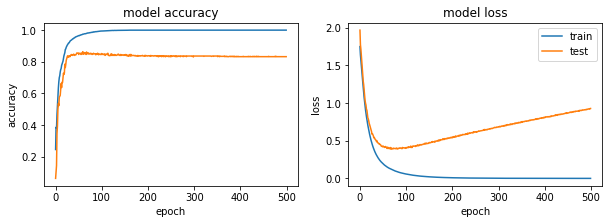

In [27]:
model = Sequential()
model.add(Dense(100,input_shape=(64*128,),activation='sigmoid'))
model.add(Dense(6, activation='softmax'))

print(model.summary())
EPOCH = 500
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCH, batch_size=256, verbose=1)

plot_history(history)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               1638600   
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 1206      
Total params: 1,639,806
Trainable params: 1,639,806
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836 samples, validate on 507 samples
Epoch 1/100
5836/5836 [==============================] - 0s 64us/step - loss: 1.7139 - accuracy: 0.2721 - val_loss: 1.8780 - val_accuracy: 0.0690
Epoch 2/100
5836/5836 [==============================] - 0s 51us/step - loss: 1.6056 - accuracy: 0.3556 - val_loss: 1.7523 - val_accuracy: 0.1815
Epoch 3/100
5836/5836 [==============================] - 0s 51us/step - loss: 1.5094 - accuracy: 0.4710 - val_loss: 1.6253 - val_accuracy: 0.3984
Epoch 4/100
5836

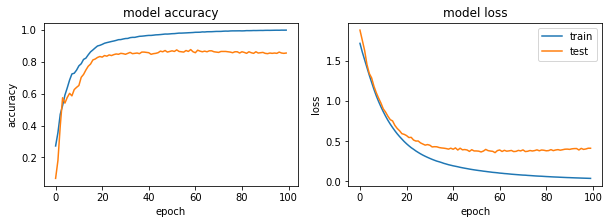

In [30]:
model = Sequential()
model.add(Dense(200,input_shape=(64*128,),activation='sigmoid'))
model.add(Dense(6, activation='softmax'))

print(model.summary())
EPOCH = 100
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCH, batch_size=256, verbose=1)

plot_history(history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 200)               1638600   
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 1206      
Total params: 1,639,806
Trainable params: 1,639,806
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836 samples, validate on 507 samples
Epoch 1/80
5836/5836 [==============================] - 0s 66us/step - loss: 1.6462 - accuracy: 0.3835 - val_loss: 1.6287 - val_accuracy: 0.4438
Epoch 2/80
5836/5836 [==============================] - 0s 51us/step - loss: 1.3508 - accuracy: 0.5692 - val_loss: 1.3190 - val_accuracy: 0.5779
Epoch 3/80
5836/5836 [==============================] - 0s 52us/step - loss: 1.0835 - accuracy: 0.6863 - val_loss: 1.0689 - val_accuracy: 0.6193
Epoch 4/80
5836/583

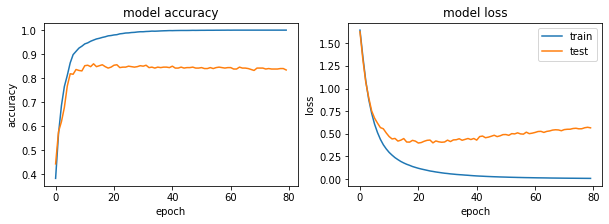

In [31]:
model = Sequential()
model.add(Dense(200,input_shape=(64*128,),activation='relu'))
model.add(Dense(6, activation='softmax'))

print(model.summary())
EPOCH = 80
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCH, batch_size=256, verbose=1)

plot_history(history)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               819300    
_________________________________________________________________
dense_12 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 126       
Total params: 821,446
Trainable params: 821,446
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836 samples, validate on 507 samples
Epoch 1/80
5836/5836 [==============================] - 0s 67us/step - loss: 1.6755 - accuracy: 0.2646 - val_loss: 1.6961 - val_accuracy: 0.3708
Epoch 2/80
5836/5836 [==============================] - 0s 44us/step - loss: 1.4241 - accuracy: 0.4957 - val_loss: 1.4315 - val_accuracy: 0.4813
Epoch 3/80
5836/5836 [==============

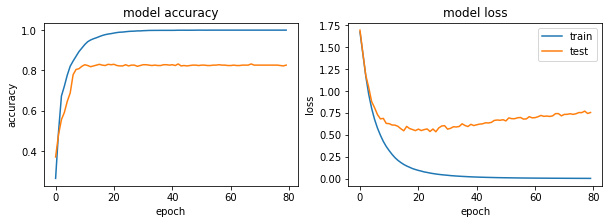

In [32]:
model = Sequential()
model.add(Dense(100,input_shape=(64*128,),activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(6, activation='softmax'))

print(model.summary())
EPOCH = 80
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCH, batch_size=256, verbose=1)

plot_history(history)

In [33]:
model = Sequential()
model.add(Dense(500,input_shape=(64*128,),activation='relu'))
model.add(Dense(6, activation='sigmoid'))

print(model.summary())
EPOCH = 20
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCH, batch_size=256, verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 500)               4096500   
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 3006      
Total params: 4,099,506
Trainable params: 4,099,506
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836 samples, validate on 507 samples
Epoch 1/20
5836/5836 [==============================] - 1s 86us/step - loss: 1.6609 - accuracy: 0.3321 - val_loss: 1.6943 - val_accuracy: 0.0888
Epoch 2/20
5836/5836 [==============================] - 0s 67us/step - loss: 1.3143 - accuracy: 0.5805 - val_loss: 1.2096 - val_accuracy: 0.5661
Epoch 3/20
5836/5836 [==============================] - 0s 65us/step - loss: 0.9080 - accuracy: 0.7473 - val_loss: 0.8564 - val_accuracy: 0.6963
Epoch 4/20
5836/583

# CNN

In [0]:
model.save('voice_model.h5')

In [36]:
from keras.layers import Conv2D, MaxPool2D
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(128,64,1),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

print(model.summary())
EPOCH = 150
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train.values.reshape(-1,128,64,1), y_train, validation_data=(X_test.values.reshape(-1,128,64,1), y_test), epochs=EPOCH, batch_size=256, verbose=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 62, 16)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 31, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 12, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 21504)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)               

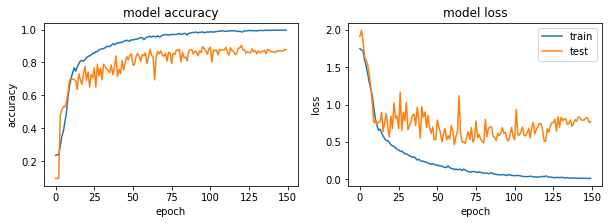

In [37]:
plot_history(history)